In [44]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [45]:
datadir = 'results/run_parsec_mesi_two_level/'

In [46]:
def getWorkingStatus(datadir, workload, size, cpu, num_cpus):
    out_file = os.path.join(datadir, workload, size, cpu, num_cpus, 'simout')
    err_file = os.path.join(datadir, workload, size, cpu, num_cpus, 'simerr')
    stat_file = os.path.join(datadir, workload, size, cpu, num_cpus, 'stats.txt')
    sys_file = os.path.join(datadir, workload, size, cpu, num_cpus, 'system.pc.com_1.device')
    
    status = ''
    lookup = 'Dump stats at the end of ROI!'
    
    try: 
        with open(out_file) as simout:
            for num, line in enumerate(simout, 1):
                if lookup in line:
                    status = 'success'
    except: #temporary change
        status = 'N/A'
        
    try: 
        with open(err_file) as f:
            l_line = f.readlines()[-1]
            if '--- END LIBC BACKTRACE ---' in l_line:
                status = 'failure'
    except:
        status = 'N/A'    
    
    try:
        with open(stat_file) as f:
            for line in f:
                if '---------- Begin Simulation Statistics ----------' in line:
                    status = 'success'
    except:
        status = 'N/A'
    
    try:
        with open(sys_file) as f:
            l_line = f.readlines()[-1]
            if '---[ end Kernel panic' in l_line:
                status = 'kernel-panic'
    except:
        status = 'N/A'                                                                          
                                                                                     
    return str(status)

In [47]:
def getStat(datadir, workload, size, cpu, num_cpus, stat):
    filename = os.path.join(datadir, workload, size, cpu, num_cpus, 'stats.txt')
    try: 
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except: #temporary change
        return 0.0

In [48]:
benchmarks = ['blackscholes', 'bodytrack', 'canneal', 'dedup','facesim', 'ferret', 'fluidanimate', 'freqmine', 'raytrace', 'streamcluster', 'swaptions', 'vips', 'x264']
kvm_num_cpus = ['1', '2', '8']
timing_num_cpus = ['1', '2']
kvm_sizes = ['simsmall', 'simlarge', 'native']
timing_sizes = ['simsmall']

In [49]:
table = []
for bench in benchmarks:
    for num_cpus in kvm_num_cpus:
        for size in kvm_sizes:  
                table.append(['KVM', num_cpus, bench, size,
                              getWorkingStatus(datadir, bench, size, 'kvm', num_cpus),
                              getStat(datadir, bench, size, 'kvm', num_cpus, 'sim_seconds'),
                              getStat(datadir, bench, size, 'kvm', num_cpus, 'sim_insts'),
                              getStat(datadir, bench, size, 'kvm', num_cpus, 'host_seconds')])
for bench in benchmarks:
    for num_cpus in timing_num_cpus:
        for size in timing_sizes:  
                table.append(['TimingSimple', num_cpus, bench, size,
                              getWorkingStatus(datadir, bench, size, 'timing', num_cpus),
                              getStat(datadir, bench, size, 'timing', num_cpus, 'sim_seconds'),
                              getStat(datadir, bench, size, 'timing', num_cpus, 'sim_insts'),
                              getStat(datadir, bench, size, 'timing', num_cpus, 'host_seconds')])

df = pd.DataFrame(table, columns = ['CPU Model', 'CPU Cores', 'Workload', 'Input Size', 
                                    'Status', 'Sim Time', 'Num Insts', 'Host Time'])

In [190]:
def plotWorkingStat(cpu):
    if cpu == 'KVM':
        num_cpus = kvm_num_cpus
        sizes = kvm_sizes
    elif cpu == 'TimingSimple':
        num_cpus = timing_num_cpus
        sizes = timing_sizes
    else:
        print('CPU model not supported')
    
    plt.figure(figsize = (16, 2))
    i = 0
    ticks = []
    labels = []
    for bench in benchmarks:
        for cores in num_cpus:
            for j, size in enumerate(sizes):
                workStat = df[(df['CPU Model'] == cpu) & (df['CPU Cores'] == cores) 
                              & (df['Workload'] == bench) & (df['Input Size'] == size)]['Status']
                workStat = list(workStat)[0]
                if workStat == 'success':
                    succ = plt.bar(i, .45, 0.9, bottom = j * 0.5, color = 'C0')
                elif workStat == 'failure':
                    fail = plt.bar(i, .45, 0.9, bottom = j * 0.5, color = 'C3')
                elif workStat == 'kernel-panic':
                    kpan = plt.bar(i, .45, 0.9, bottom = j * 0.5, color = 'C4')
                elif workStat == 'N/A':
                    time = plt.bar(i, .45, 0.9, bottom = j * 0.5, color = 'C1')
                else:
                    unkn = plt.bar(i, .45, 0.9, bottom = j * 0.5, color = 'C5')
            ticks.append(i)
            labels.append(str(cores))
            i = i + 1
        i = i + 1
        
    if cpu == 'KVM':
        plt.yticks([0.25, 0.75, 1.25], ['simsmall', 'simlarge', 'native'])
    else:
        plt.yticks([0.25], ['simsmall'])
    plt.suptitle('Working Status of the benchmarks using ' + cpu + 'CPU model')
    plt.xlabel('Number of cores')
    plt.xticks(ticks, labels, rotation = 'vertical')
    if cpu == 'TimingSimple':
        plt.legend((succ, kpan), ('success', 'kernel-panic'))

In [207]:
def plotStat(cpu, cores, stat):
    if cpu == 'KVM':
        num_cpus = kvm_num_cpus
        sizes = kvm_sizes
    elif cpu == 'TimingSimple':
        num_cpus = timing_num_cpus
        sizes = timing_sizes
    else:
        print('CPU model not supported')
    
    plt.figure(figsize = (16, 2))
    i = 0
    ticks = []
    labels = []
    for bench in benchmarks:
        for j, size in enumerate(sizes):
            data = df[(df['CPU Model'] == cpu) & (df['CPU Cores'] == cores) 
                          & (df['Workload'] == bench) & (df['Input Size'] == size)][stat]
            data = float(list(data)[0])
            plt.bar(i, data, 0.7, color = 'C' + str(j))
            ticks.append(i)
            labels.append(size)
            i = i + 1
        i = i + 1
    plt.suptitle(stat + ' with ' + cores + ' ' + cpu + ' CPUs')
    plt.xticks(ticks, labels, rotation = 'vertical')

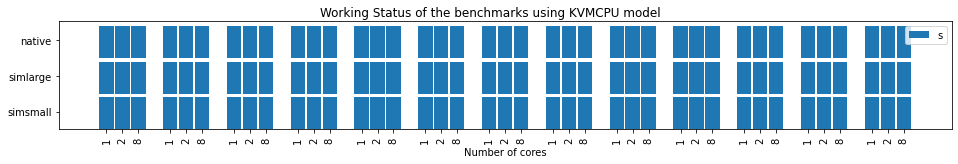

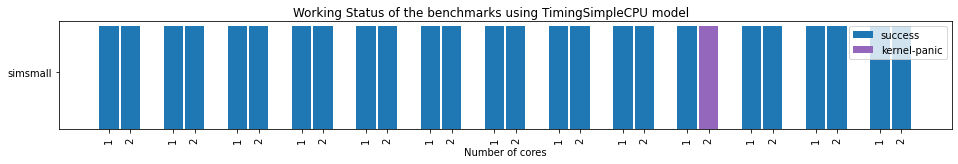

In [208]:
plotWorkingStat('KVM')
plotWorkingStat('TimingSimple')

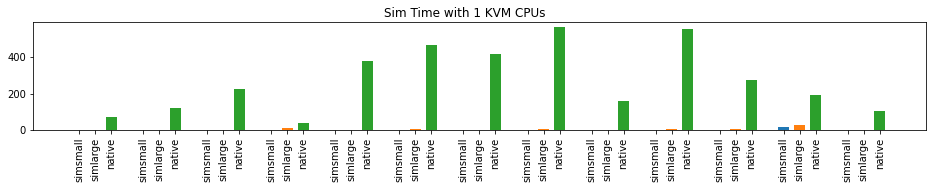

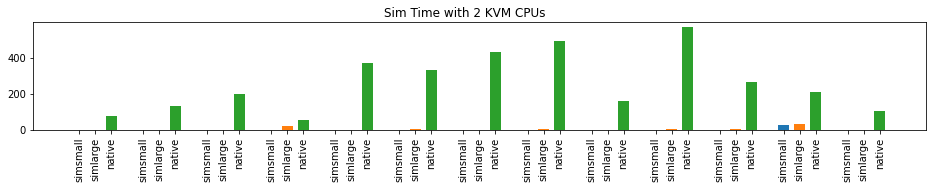

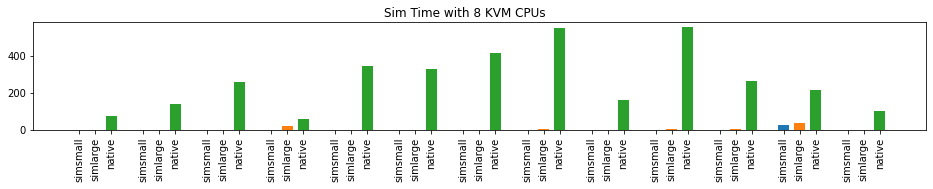

In [209]:
plotStat('KVM', '1', 'Sim Time')
plotStat('KVM', '2', 'Sim Time')
plotStat('KVM', '8', 'Sim Time')

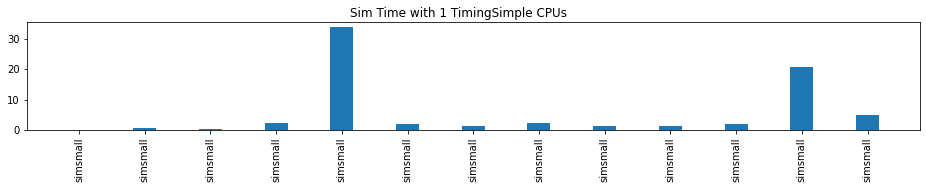

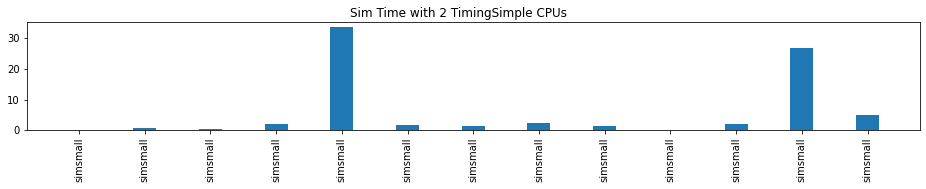

In [210]:
plotStat('TimingSimple', '1', 'Sim Time')
plotStat('TimingSimple', '2', 'Sim Time')

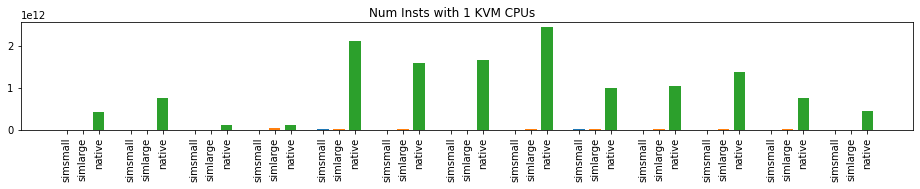

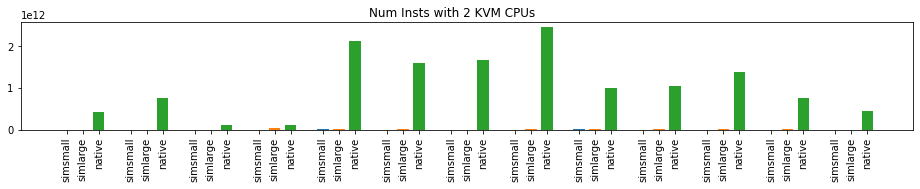

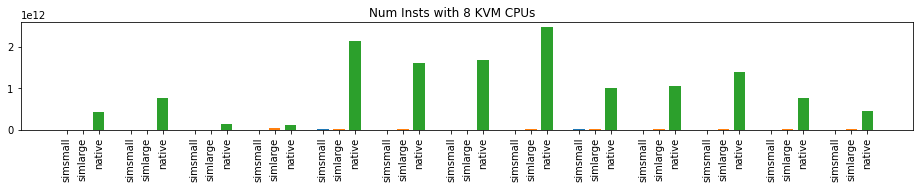

In [211]:
plotStat('KVM', '1', 'Num Insts')
plotStat('KVM', '2', 'Num Insts')
plotStat('KVM', '8', 'Num Insts')

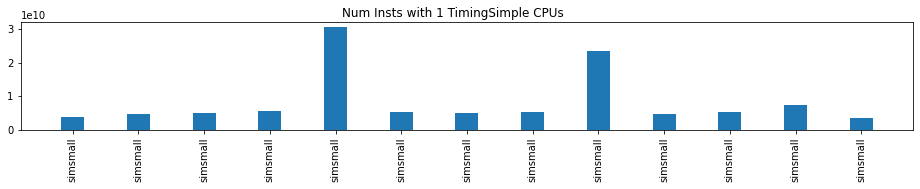

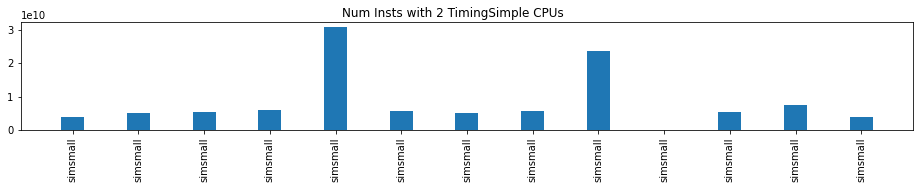

In [212]:
plotStat('TimingSimple', '1', 'Num Insts')
plotStat('TimingSimple', '2', 'Num Insts')